In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=3267faaa4affa9a523e6a66f64e6c01af963d78b6a45baf6647efaa577078d2e
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import numpy as np
import os

import gzip
import pickle
import sys
import wget
import random
import matplotlib.pyplot as plt

In [0]:
if not os.path.exists(os.path.join(os.curdir, "data")):
  os.mkdir(os.path.join(os.curdir, "data"))

In [5]:
 wget.download("http://deeplearning.net/data/mnist/mnist.pkl.gz", out="data")

'data/mnist.pkl.gz'

#Load Dataset

In [0]:
def load_mnist():
    # if not os.path.exists(os.path.join(os.curdir, "data")):
    #     os.mkdir(os.path.join(os.curdir, "data"))
    #     wget.download("http://deeplearning.net/data/mnist/mnist.pkl.gz", out="data")

    data_file = gzip.open(os.path.join(os.curdir, "data", "mnist.pkl.gz"), "rb")
    train_data, val_data, test_data = pickle.load(data_file, encoding="latin1")
    data_file.close()

    train_inputs = [np.reshape(x, (784, 1)) for x in train_data[0]]
    train_results = [vectorized_result(y) for y in train_data[1]]
    train_data = list(zip(train_inputs, train_results))

    val_inputs = [np.reshape(x, (784, 1)) for x in val_data[0]]
    val_results = val_data[1]
    val_data = list(zip(val_inputs, val_results))

    test_inputs = [np.reshape(x, (784, 1)) for x in test_data[0]]
    test_data = list(zip(test_inputs, test_data[1]))
    return train_data, val_data, test_data


In [0]:
def vectorized_result(y):
    e = np.zeros((10, 1))
    e[y] = 1.0
    return e

# Activation methods and derivatives

In [0]:
class Activations:
  def sigmoid(self, z):
    return 1.0 / (1.0 + np.exp(-z))


  def sigmoid_prime(self, z):
      return sigmoid(z) * (1 - sigmoid(z))


  def softmax(self, z):
      return np.exp(z) / np.sum(np.exp(z))


  def tanh(self, z):
      return np.tanh(z)


  def tanh_prime(self, z):
      return 1 - tanh(z) * tanh(z)


  def relu(self,z):
      return np.maximum(z, 0)


  def relu_prime(self,z):
      return z > 0

## Forward Propagation

In [0]:
def _forward_prop(x, num_layers,_activations,_zs,activation_fn,weights,biases):
  _activations[0] = x
  for i in range(1, num_layers):
    _zs[i] = (
      weights[i].dot(_activations[i - 1]) + biases[i]
    )

    # Use "softmax" for last layer.
    if i == num_layers - 1:
      _activations[i] = Activations().softmax(_zs[i])
    else:
      _activations[i] = activation_fn(_zs[i])
  return _activations, _zs

## Back propagation

In [0]:
def _back_prop(x, y,weights, biases, _activations,num_layers, _zs):
  nabla_b = [np.zeros(bias.shape) for bias in biases]
  nabla_w = [np.zeros(weight.shape) for weight in weights]

  error = (_activations[-1] - y)
  nabla_b[-1] = error
  nabla_w[-1] = error.dot(_activations[-2].transpose())

  for l in range(num_layers - 2, 0, -1):
    error = np.multiply(
      weights[l + 1].transpose().dot(error),
      activation_fn_prime(_zs[l])
    )
    nabla_b[l] = error
    nabla_w[l] = error.dot(_activations[l - 1].transpose())

  return nabla_b, nabla_w

## Train model with 3 layer neural network

In [0]:
def train(training_data, validation_data,layers, _activations,_zs,activation_fn,epochs, mini_batch_size, weights, biases,lr):
  num_layers = len(layers)

  for epoch in range(epochs):
    random.shuffle(training_data)
    mini_batches = [training_data[k:k + mini_batch_size] for k in range(0, len(training_data), mini_batch_size)]
 
    for mini_batch in mini_batches:
      nabla_b = [np.zeros(bias.shape) for bias in biases]
      nabla_w = [np.zeros(weight.shape) for weight in weights]
      #print(mini_batch)
      for x, y in mini_batch:
        _activations,_zs = _forward_prop(x,num_layers,_activations,_zs,activation_fn,weights,biases)
        delta_nabla_b, delta_nabla_w = _back_prop(x, y,weights, biases, _activations,num_layers, _zs)
        nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        weights = [
                      w - (lr / mini_batch_size) * dw for w, dw in
                      zip(weights, nabla_w)]
        biases = [
                      b - (lr / mini_batch_size) * db for b, db in
                      zip(biases, nabla_b)]

    if validation_data:
      accuracy = validate(validation_data,num_layers,_activations,_zs,weights,biases) / 100.0
      print(f"Epoch {epoch + 1}, accuracy {accuracy} %.")
    else:
        print(f"Processed epoch {epoch}.")
          

In [0]:
def validate(validation_data,num_layers,_activations,_zs,weights,biases):
  validation_results = [(predict(x,num_layers,_activations,_zs,weights,biases) == y) for x, y in validation_data]
  return sum(result for result in validation_results)

## Validate model

In [0]:
def predict(x,num_layers,_activations,_zs,weights,biases):
  _forward_prop(x,num_layers,_activations,_zs,activation_fn,weights,biases)
  return np.argmax(_activations[-1])

## Initialize variable

In [0]:
train_data, val_data, test_data = load_mnist()


In [15]:
len(train_data)

50000

## Mini batch gradient descent

In [0]:
np.random.seed(42)

layers = [784, 64,32, 10]
learning_rate = 0.01
mini_batch_size = 16
epochs = 10
activation_name ="relu"
sizes = layers
weights = [np.array([0])] + [np.random.randn(y, x)/np.sqrt(x) for y, x in
                                          zip(sizes[1:], sizes[:-1])]

biases = [np.array([0])] + [np.random.randn(y, 1) for y in sizes[1:]]
_zs = [np.zeros(bias.shape) for bias in biases]
_activations = [np.zeros(bias.shape) for bias in biases]
#Load data
activation_fn = getattr(Activations(), activation_name)
activation_fn_prime = getattr(Activations(), f"{activation_name}_prime")


In [17]:
len(val_data)

10000

**Training with mini batch size of 16 for 10 epochs with learning rate of 0.01**

In [18]:
train(train_data, val_data,layers, _activations,_zs,activation_fn,epochs,mini_batch_size, weights, biases,learning_rate)

Epoch 1, accuracy 94.89 %.
Epoch 2, accuracy 95.19 %.
Epoch 3, accuracy 94.51 %.
Epoch 4, accuracy 96.13 %.
Epoch 5, accuracy 95.64 %.
Epoch 6, accuracy 96.41 %.
Epoch 7, accuracy 96.86 %.
Epoch 8, accuracy 95.08 %.
Epoch 9, accuracy 96.58 %.
Epoch 10, accuracy 96.78 %.


**Training with mini batch size of 64 for 10 epochs with learning rate of 0.001**

In [0]:
np.random.seed(42)

layers = [784, 64,32, 10]
learning_rate = 0.001
mini_batch_size = 64
epochs = 10
activation_name ="relu"
sizes = layers
weights = [np.array([0])] + [np.random.randn(y, x)/np.sqrt(x) for y, x in
                                          zip(sizes[1:], sizes[:-1])]

biases = [np.array([0])] + [np.random.randn(y, 1) for y in sizes[1:]]
_zs = [np.zeros(bias.shape) for bias in biases]
_activations = [np.zeros(bias.shape) for bias in biases]
#Load data
activation_fn = getattr(Activations(), activation_name)
activation_fn_prime = getattr(Activations(), f"{activation_name}_prime")

In [25]:
train(train_data, val_data,layers, _activations,_zs,activation_fn,epochs,mini_batch_size, weights, biases,learning_rate)

Epoch 1, accuracy 90.12 %.
Epoch 2, accuracy 91.85 %.
Epoch 3, accuracy 92.93 %.
Epoch 4, accuracy 93.9 %.
Epoch 5, accuracy 94.47 %.
Epoch 6, accuracy 94.71 %.
Epoch 7, accuracy 95.46 %.
Epoch 8, accuracy 95.36 %.
Epoch 9, accuracy 95.83 %.
Epoch 10, accuracy 96.17 %.


**Training with mini batch of 256 for 20 epochs with learning rate of 0.01**




In [0]:
np.random.seed(42)

layers = [784, 64,32, 10]
learning_rate = 0.01
mini_batch_size = 256
epochs = 20
activation_name ="relu"
sizes = layers
weights = [np.array([0])] + [np.random.randn(y, x)/np.sqrt(x) for y, x in
                                          zip(sizes[1:], sizes[:-1])]

biases = [np.array([0])] + [np.random.randn(y, 1) for y in sizes[1:]]
_zs = [np.zeros(bias.shape) for bias in biases]
_activations = [np.zeros(bias.shape) for bias in biases]
#Load data
activation_fn = getattr(Activations(), activation_name)
activation_fn_prime = getattr(Activations(), f"{activation_name}_prime")

In [36]:
train(train_data, val_data,layers, _activations,_zs,activation_fn,epochs,mini_batch_size, weights, biases,learning_rate)

Epoch 1, accuracy 94.32 %.
Epoch 2, accuracy 95.45 %.
Epoch 3, accuracy 95.53 %.
Epoch 4, accuracy 96.11 %.
Epoch 5, accuracy 96.6 %.
Epoch 6, accuracy 96.04 %.
Epoch 7, accuracy 96.62 %.
Epoch 8, accuracy 96.89 %.
Epoch 9, accuracy 96.72 %.
Epoch 10, accuracy 96.42 %.
Epoch 11, accuracy 96.88 %.
Epoch 12, accuracy 97.09 %.
Epoch 13, accuracy 96.9 %.
Epoch 14, accuracy 96.48 %.
Epoch 15, accuracy 96.78 %.
Epoch 16, accuracy 96.55 %.
Epoch 17, accuracy 97.2 %.
Epoch 18, accuracy 96.79 %.
Epoch 19, accuracy 96.44 %.
Epoch 20, accuracy 96.99 %.


# Data Augmentation

In [19]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical


Using TensorFlow backend.


In [0]:
class DataAugmentation:
    def __init__(self):
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()
        # reshape
        self.x_train = self.x_train.reshape(self.x_train.shape[0], 28, 28, 1)
        self.x_test = self.x_test.reshape(self.x_test.shape[0], 28, 28, 1)
        # convert from int to float
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        # rescale values
        self.x_train /= 255.0
        self.x_test /= 255.0
        # Save dataset sizes
        self.train_size = self.x_train.shape[0]
        self.test_size = self.x_test.shape[0]
        # Create one hot array
        self.y_train = to_categorical(self.y_train, 10)
        self.y_test = to_categorical(self.y_test, 10)
    def data_augmentation(self, augment_size=5000):
        image_generator = ImageDataGenerator(
            rotation_range=10,
            zoom_range = 0.05,
            width_shift_range=0.05,
            height_shift_range=0.05,
            horizontal_flip=False,
            vertical_flip=False,
            data_format="channels_last",
            zca_whitening=True)
        # fit data for zca whitening
        image_generator.fit(self.x_train, augment=True)
        # get transformed images
        randidx = np.random.randint(self.train_size, size=augment_size)
        x_augmented = self.x_train[randidx].copy()
        y_augmented = self.y_train[randidx].copy()
        x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size),
                                    batch_size=augment_size, shuffle=False).next()[0]
        # append augmented data to trainset
        self.x_train = np.concatenate((self.x_train, x_augmented))
        self.y_train = np.concatenate((self.y_train, y_augmented))
        self.train_size = self.x_train.shape[0]
        self.test_size = self.x_test.shape[0]


    def next_train_batch(self, batch_size):
        randidx = np.random.randint(self.train_size, size=batch_size)
        epoch_x = self.x_train[randidx]
        epoch_y = self.y_train[randidx]
        return epoch_x, epoch_y

    def next_test_batch(self, batch_size):
        randidx = np.random.randint(self.test_size, size=batch_size)
        epoch_x = self.x_test[randidx]
        epoch_y = self.y_test[randidx]
        return epoch_x, epoch_y

    def shuffle_train(self):
        indices = np.random.permutation(self.train_size)
        self.x_train = self.x_train[indices]
        self.y_train = self.y_train[indices]

In [0]:
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

In [21]:
model = DataAugmentation()
print('Previous train images: ',model.train_size)
print('Previous train images: ',model.test_size)

model.data_augmentation(augment_size = 1000)
print('After train images: ',model.train_size)
print('After train images: ',model.test_size)

11493376/11490434 [==============================] - 0s 0us/step
Previous train images:  60000
Previous train images:  10000


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


After train images:  61000
After train images:  10000


In [22]:
# let's print the shape before we reshape and normalize
print("X_train shape", model.x_train.shape)
print("y_train shape", model.y_train.shape)
print("X_test shape", model.x_test.shape)
print("y_test shape", model.y_test.shape)

# building the input vector from the 28x28 pixels
model.x_train = model.x_train.reshape(61000, 784)
model.x_test = model.x_test.reshape(10000, 784)
model.x_train = model.x_train.astype('float32')
model.x_test = model.x_test.astype('float32')

# normalizing the data to help with the training
model.x_train /= 255
model.x_test /= 255

# print the final input shape ready for training
print("Train matrix shape", model.x_train.shape)
print("Test matrix shape", model.x_test.shape)

X_train shape (61000, 28, 28, 1)
y_train shape (61000, 10)
X_test shape (10000, 28, 28, 1)
y_test shape (10000, 10)
Train matrix shape (61000, 784)
Test matrix shape (10000, 784)


In [27]:
  X_train = model.x_train
  Y_train = model.y_train
  X_test = model.x_test
  Y_test = model.y_test
  
  dropout = 0.2
  model = Sequential()
  model.add(Dense(512, input_shape=(784,)))
  model.add(Activation('relu'))                            
  model.add(Dropout(dropout))

  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(dropout))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
  history = model.fit(X_train, Y_train,
          batch_size=128, epochs=20,
          verbose=2,
          validation_data=(X_test, Y_test))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 61000 samples, validate on 10000 samples
Epoch 1/20





 - 9s - loss: 0.8173 - acc: 0.7544 - val_loss: 0.3604 - val_acc: 0.8938
Epoch 2/20
 - 8s - loss: 0.3524 - acc: 0.8970 - val_loss: 0.2714 - val_acc: 0.9221
Epoch 3/20
 - 8s - loss: 0.2767 - acc: 0.9178 - val_loss: 0.2162 - val_acc: 0.9365
Epoch 4/20
 - 8s - loss: 0.2228 - acc: 0.9346 - val_loss: 0.1800 - val_acc: 0.9457
Epoch 5/20
 - 8s - loss: 0.1827 - acc: 0.9448 - val_loss: 0.1497 - val_acc: 0.9552
Epoch 6/20
 - 8s - loss: 0.1557 - acc: 0.9534 - val_loss: 0.1292 - val_acc: 0.9587
Epoch 7/20
 - 8s - loss: 0.1358 - acc: 0.9597 - val_loss: 0.1150 - val_acc: 0.9636
Epoch 8/20
 - 8s - loss: 0.1194 - acc: 0.9642 - val_loss: 0.1061 - val_acc: 0.9676
Epoch 9/20
 - 8s - loss: 0.1056 - acc: 0.9682 - val_loss: 0.093

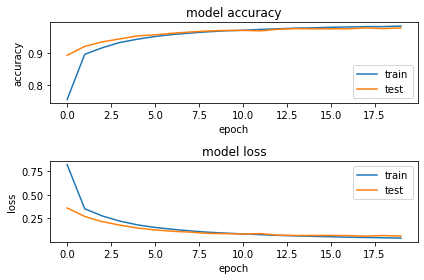

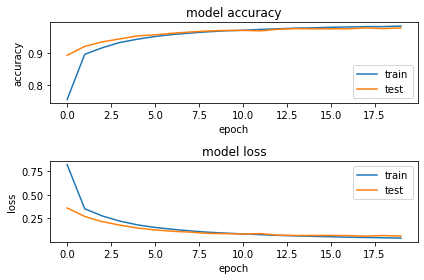

In [28]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

# Dropout 

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

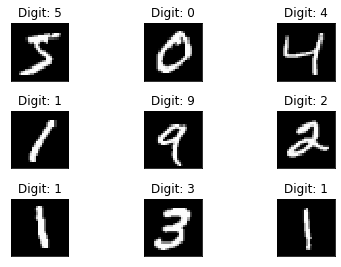

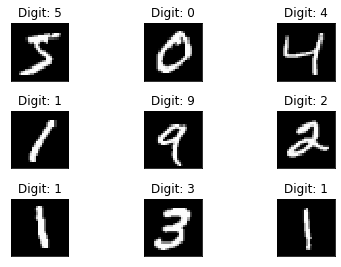

In [30]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [31]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


In [32]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


In [0]:
  dropout = 0.2
  model = Sequential()
  model.add(Dense(512, input_shape=(784,)))
  model.add(Activation('relu'))                            
  model.add(Dropout(dropout))

  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(dropout))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
 
  


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 8s - loss: 0.2500 - acc: 0.9242 - val_loss: 0.1132 - val_acc: 0.9648
Epoch 2/20
 - 8s - loss: 0.1033 - acc: 0.9681 - val_loss: 0.0749 - val_acc: 0.9762
Epoch 3/20
 - 8s - loss: 0.0705 - acc: 0.9777 - val_loss: 0.0703 - val_acc: 0.9771
Epoch 4/20
 - 8s - loss: 0.0562 - acc: 0.9816 - val_loss: 0.0660 - val_acc: 0.9787
Epoch 5/20
 - 8s - loss: 0.0474 - acc: 0.9850 - val_loss: 0.0613 - val_acc: 0.9796
Epoch 6/20
 - 8s - loss: 0.0390 - acc: 0.9876 - val_loss: 0.0620 - val_acc: 0.9821
Epoch 7/20
 - 8s - loss: 0.0329 - acc: 0.9893 - val_loss: 0.0542 - val_acc: 0.9837
Epoch 8/20
 - 8s - loss: 0.0286 - acc: 0.9908 - val_loss: 0.0601 - val_acc: 0.9815
Epoch 9/20
 - 8s - loss: 0.0269 - acc: 0.9909 - val_loss: 0.0662 - val_acc: 0.9812
Epoch 10/20
 - 8s - loss: 0.0271 - acc: 0.9907 - val_loss: 0.0584 - val_acc: 0.9830
Epoch 11/20
 - 8s - loss: 0.0231 - acc: 0.9920 - val_loss: 0.0630 - val_acc: 0.9817
Epoch 12/20
 - 8s - loss: 0.0212 - 

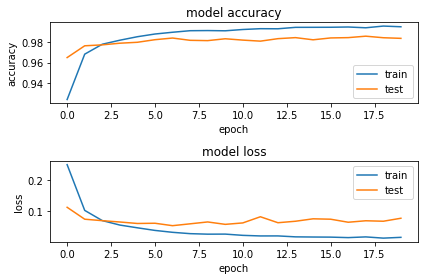

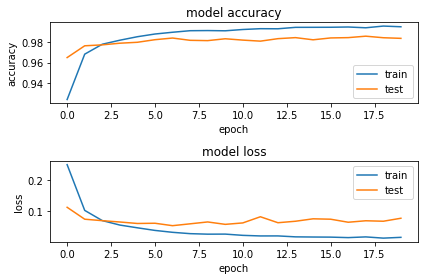

In [34]:
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=20,
          verbose=2,
          validation_data=(X_test, Y_test))
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

## Trying different dropout for each layer 

In [0]:
  model = Sequential()
  model.add(Dense(512, input_shape=(784,)))
  model.add(Activation('relu'))                            
  model.add(Dropout(0.2))

  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 9s - loss: 0.2553 - acc: 0.9229 - val_loss: 0.1083 - val_acc: 0.9667
Epoch 2/20
 - 8s - loss: 0.1057 - acc: 0.9678 - val_loss: 0.0814 - val_acc: 0.9744
Epoch 3/20
 - 8s - loss: 0.0758 - acc: 0.9760 - val_loss: 0.0744 - val_acc: 0.9778
Epoch 4/20
 - 8s - loss: 0.0591 - acc: 0.9809 - val_loss: 0.0710 - val_acc: 0.9778
Epoch 5/20
 - 8s - loss: 0.0470 - acc: 0.9847 - val_loss: 0.0646 - val_acc: 0.9812
Epoch 6/20
 - 8s - loss: 0.0404 - acc: 0.9872 - val_loss: 0.0736 - val_acc: 0.9790
Epoch 7/20
 - 8s - loss: 0.0339 - acc: 0.9886 - val_loss: 0.0632 - val_acc: 0.9805
Epoch 8/20
 - 8s - loss: 0.0336 - acc: 0.9886 - val_loss: 0.0699 - val_acc: 0.9811
Epoch 9/20
 - 8s - loss: 0.0310 - acc: 0.9897 - val_loss: 0.0668 - val_acc: 0.9813
Epoch 10/20
 - 8s - loss: 0.0259 - acc: 0.9914 - val_loss: 0.0715 - val_acc: 0.9819
Epoch 11/20
 - 8s - loss: 0.0254 - acc: 0.9920 - val_loss: 0.0769 - val_acc: 0.9815
Epoch 12/20
 - 8s - loss: 0.0231 - 

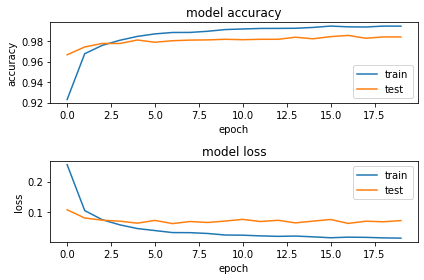

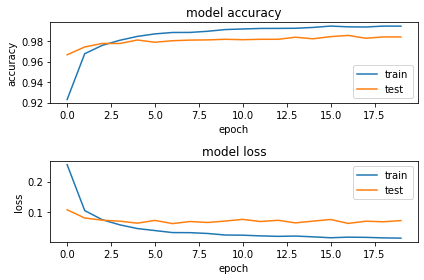

In [38]:
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=20,
          verbose=2,
          validation_data=(X_test, Y_test))
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

#Results Comparison

Hyperparameter analysis

1.   Mini-batch size of 16, 10 epochs for Learning rate 0.01 : accuracy 96.78%
2.   Mini-batch size of 64, 10 epochs for Learning rate 0.001 : accuracy 96.17%
3. Mini-batch size of 256, 20 epochs for Learning rate 0.01 : accuracy 96.99%
4. Data Augmentation increasing data volume by 10%: accuracy 98.06%
5. Dropout with equal dropout value for all layers : accuracy 98.34%
6. Dropout with different dropout value for all layers : accuracy 98.42%

